In [170]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score
import re
import random

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [171]:
train_file = 'train.csv'
test_file = 'test.csv'

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

In [172]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [173]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [174]:
train_y = train_data['Survived']
train_X = train_data.drop(['Survived', 'Ticket', 'Cabin'], axis=1)

test_X = test_data.drop(['Ticket', 'Cabin'], axis=1)

In [175]:
train_X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [176]:
train_X['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [177]:
test = 'Johnston, Miss. Catherine Helen "Carrie"'
a = re.search('([A-Z])\w+\.', 'Johnston, Miss. Catherine Helen "Carrie"')
print(a.group(0).replace('.',''))

Miss


In [178]:
names = train_X['Name'].copy()
prefix = []

names_test = test_X['Name'].copy()
prefix_test = []

In [179]:
prefix_order = {'Miss': 2, 'Mr': 3, 'Mrs': 4, 
               'Master': 5, 'Other': 1}


In [180]:
for i, name in enumerate(names):
    pfx = re.search('([A-Z])\w+\.', name)
    
    try:
        prefix.append(prefix_order[pfx.group(0).replace('.','')])
    except:
        prefix.append(1)
        

In [181]:
for i, name in enumerate(names_test):
    pfx_test = re.search('([A-Z])\w+\.', name)
    
    try:
        prefix_test.append(prefix_order[pfx_test.group(0).replace('.','')])
    except:
        prefix_test.append(1)

In [182]:
s_a_sb_p = train_X.iloc[:,3:7].copy()
s_a_sb_p.head()


,Sex,Age,SibSp,Parch
0,male,22.0,1,0
1,female,38.0,1,0
2,female,26.0,0,0
3,female,35.0,1,0
4,male,35.0,0,0


In [183]:
ages = []

for i, row in s_a_sb_p.iterrows():
    sex, age, n_sp, n_child = row
    if str(age) == 'nan':
        if n_child > 0 or n_sp > 0:
            ages.append(float(random.randint(20, 40)))
        else:
            ages.append(float(random.randint(18, 30)))
        
        
    else:
        ages.append(age)


In [184]:
test_X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


In [185]:
s_a_sb_p_test = test_X.iloc[:,3:7].copy()
s_a_sb_p_test.head()


,Sex,Age,SibSp,Parch
0,male,34.5,0,0
1,female,47.0,1,0
2,male,62.0,0,0
3,male,27.0,0,0
4,female,22.0,1,1


In [186]:
ages_test = []

for i, row in s_a_sb_p_test.iterrows():
    sex, age, n_sp, n_child = row
    if str(age) == 'nan':
        if n_child > 0 or n_sp > 0:
            ages_test.append(float(random.randint(20, 40)))
        else:
            ages_test.append(float(random.randint(18, 30)))
        
        
    else:
        ages_test.append(age)


In [187]:
map_e = {'C': 1, 'S':3, 'Q':2}

emb = train_X['Embarked'].copy()
embarks = []

In [188]:
for em in emb:
    try:
        x = map_e[str(em)]
        embarks.append(x)
    except:
        embarks.append(2)


In [189]:
emb_test = test_X['Embarked'].copy()
embarks_test = []

In [190]:
for em in emb_test:
    try:
        x = map_e[str(em)]
        embarks_test.append(x)
    except:
        embarks_test.append(2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f829bf3a6a0>,
      dtype=object)

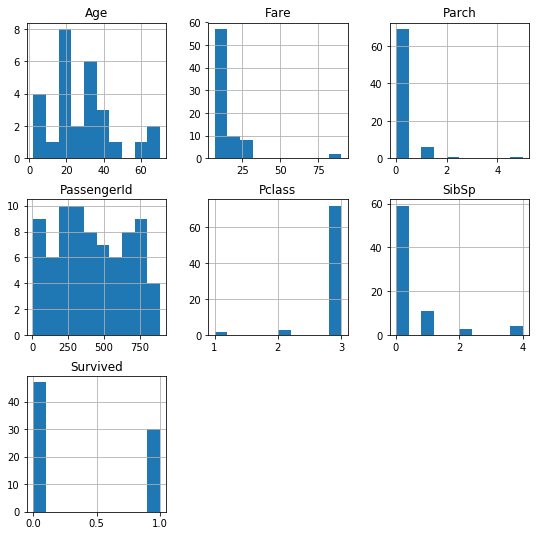

In [191]:
train_data.query('Embarked == "Q"').hist(figsize=(9,9))

In [192]:
train_X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [193]:
train_X.drop(['Name', 'Age', 'Embarked'], axis=1, inplace=True)
test_X.drop(['Name', 'Age', 'Embarked'], axis=1, inplace=True)

train_X['Prefix'] = prefix
train_X['Age'] = ages
train_X['Embarked'] = embarks

test_X['Prefix'] = prefix_test
test_X['Age'] = ages_test
test_X['Embarked'] = embarks_test

In [194]:
train_X.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Prefix,Age,Embarked
0,1,3,male,1,0,7.2500,3,22.0,3
1,2,1,female,1,0,71.2833,4,38.0,1
2,3,3,female,0,0,7.9250,2,26.0,3
3,4,1,female,1,0,53.1000,4,35.0,3
4,5,3,male,0,0,8.0500,3,35.0,3


In [195]:
train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_X)


In [161]:
cols_with_missing_values = [col for col in train_X.columns 
                            if train_X[col].isnull().any()]

for col in cols_with_missing_values:
    train_X[col + 'was_missing'] = train_X[col].isnull()
    test_X[col + 'was_missing'] = test_X[col].isnull()
    

In [162]:
train_X.head()

,PassengerId,Pclass,SibSp,Parch,Fare,Prefix,Age,Embarked,Sex_female,Sex_male
0,1,3,1,0,7.2500,3,22.0,3,0,1
1,2,1,1,0,71.2833,4,38.0,1,1,0
2,3,3,0,0,7.9250,2,26.0,3,1,0
3,4,1,1,0,53.1000,4,35.0,3,1,0
4,5,3,0,0,8.0500,3,35.0,3,0,1


In [196]:
train_X, test_X = train_X.align(test_X, join='left', axis=1)

In [211]:
imputer = SimpleImputer()

train_X = imputer.fit_transform(train_X)
test_X = imputer.transform(test_X)

In [423]:
params = {'min_samples_leaf':[1, 2, 3,4, 8, 10,],
         'max_depth':[1,2,3,4,6],
         'max_leaf_nodes':[6,8,9,10,11],
         'n_estimators':[10,50,100]}

In [424]:
#after testing some hyperparams got n_estimators=1000, learning_rate=0.001, min_child_weight=1, max_depth=8, gamma=0.1 with bests results
gridSearch = GridSearchCV(RandomForestClassifier(), params, scoring='accuracy', n_jobs=4, cv=5)

In [425]:
gridSearch.fit(train_X, train_y)



GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'min_samples_leaf': [1, 2, 3, 4, 8, 10], 'max_depth': [1, 2, 3, 4, 6], 'max_leaf_nodes': [6, 8, 9, 10, 11], 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [426]:
gridSearch.best_params_ , gridSearch.best_score_ 

({'max_depth': 6,
  'max_leaf_nodes': 10,
  'min_samples_leaf': 4,
  'n_estimators': 50},
 0.8305274971941639)

In [197]:
model = XGBClassifier(n_estimators=1000, learning_rate=0.001, min_child_weight=1, max_depth=8, gamma=0.1, n_jobs=4)

In [451]:
model = RandomForestClassifier(n_estimators=50, min_samples_leaf=4, max_depth=6, max_leaf_nodes=10, n_jobs=4)

In [452]:
scores = cross_val_score(model, train_X, train_y, scoring='accuracy', cv=5, n_jobs=-1)

In [453]:
print(scores.mean() * 100)

82.154705302209


In [455]:
pipeline = make_pipeline(SimpleImputer(), model)


In [454]:
model.fit(train_X, train_y)
predictions = model.predict(test_X)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [456]:
pipeline.fit(train_X, train_y)

Pipeline(memory=None,
     steps=[('simpleimputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=0)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=10,
        ...n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [457]:
predictions = pipeline.predict(test_X)

In [458]:
predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [459]:
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": predictions
    })
submission.to_csv('submission_f.csv', index=False)